In [2]:
import gymnasium
from gymnasium import error, spaces, utils, Env
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

Matplotlib is building the font cache; this may take a moment.


# Descripción del problema

El siguiente ejemplo consiste en un Ambiente (Room). La temperatura de la habitación cambia debido a la temperatura externa ambiente (se asume de forma desconocida). La habitación cuenta con un equipo de Aire Acondicionado controlado por un Agente. El objetivo de este Agente es mantener la temperatura en 0 grados. El Aire Acondicionado puede cambiar la temperatura en 0, 1, 2 o 3 grados ya sea frío o calor.

# Ambiente

El ambiente (Room) está simulado por el siguiente código

In [3]:
class Room(Env):
    
    def __init__(self):
        self.observation_space = spaces.Box(low=-20, high=40, shape=(), dtype=np.float32)
        self.action_space = spaces.Discrete(7, start=-3)
                  
    def reset(self):
        self.step_count = 0
        self.initial_random = self.observation_space.sample()
        self.external_temp = 0
        self.external_temp = self._temp_variation()
        self.temp = self.external_temp
        return self.temp
    
    def step(self, action):
        delta_temp = self._temp_variation()
        self.external_temp += delta_temp
        self.temp += delta_temp + action
        self.step_count += 1
        return self.temp

    def _temp_variation(self):
        x = self.initial_random + self.step_count
        return np.float64('%.2f'%(20 * np.sin(x/10))) - self.external_temp 
          

# Test Room

In [4]:
env = Room()

In [5]:
env.observation_space

Box(-20.0, 40.0, (), float32)

In [6]:
env.observation_space.sample()

array(2.9444077, dtype=float32)

In [7]:
env.action_space

Discrete(7, start=-3)

In [8]:
env.action_space.sample()

np.int64(2)

In [9]:
env.reset()

np.float64(-19.03)

# Reflex Agent

Esta es la implementación de un Agente Reflejo Simple, que dada la observación (temperatura de la habitación), toma una acción de enfriar o calentar en 0, 1, 2 o 3 grados. El agente solo enfría o calienta si la temperatura difiere en más de 2 grados.

In [ ]:
class AgentReflex():

    def lookup(self, obs):
        if obs > 9:
            return -3
        elif obs > 5:
            return -2
        elif obs > 2:
            return -1
        elif obs < -9:
            return 3
        elif obs < -5:
            return 2
        elif obs < -2:
            return 1
        else:
            return 0

# Test Reflex

In [ ]:
agent = AgentReflex()

In [ ]:
obs = env.reset()
external_res = []
agent_res = []
total_steps = 100

## Execution

In [ ]:
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = agent.lookup(obs)
    obs = env.step(action)
    agent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

## Graficando los resultados

In [ ]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), agent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente

## Métrica de Performance
Una posible métrica de performance, podría ser ver la temperatura media del ambiente con la acción del agente.

In [ ]:
print("Temperatura media con el agente: ", np.mean(agent_res))
print("Temperatura media sin el agente: ", np.mean(external_res))

Otra posible métrica de performance, es evaluar para cada instante de tiempo (step) cuanto difiere la temperatura obtenida de la objetivo=0. Esto se puede hacer con mean_squared_error o mean_absolute_error. 
Comparemos la métrica obtenida por el agente contra la métrica obtenida sin un agente:

In [ ]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente: ", mean_absolute_error(goal_temp, agent_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res))

# Ejercicio: Model (Goal / Utility) Based Agent 

Construir un Agente basado en un modelo. 
Esto es: 
    - Construir un modelo a mano, por ejemplo un grafo, con estados y transiciones [Ver figura].
    - Discretizar las observaciones devueltas por el ambiente mapeándolas a un estado.
    - Tomar una decisón basada en el estado.
    - Definir un objetivo y una utilidad

Por ejemplo, el Agente podría conocer un modelo que tiene 2 estados {Frío, Calor}
<img src="Modelo.png">


# Model Based Agent

In [48]:
class SimpleModel():
    def __init__(self):
        self.actions = {
            "Frio": {"state": "Frio", "action": "calentar", "amount": 1},
            "Calor": {"state": "Calor", "action": "enfriar", "amount": -1},
            "Neutro": {"state": "Neutro", "action": "mantener", "amount": 0}
        }

    def get_state(self, obs):
        if obs < 0:
            return "Frio"
        elif obs > 0:
            return "Calor"
        else:
            return "Neutro"

    def get_action(self, state):
        return self.actions[state]

In [57]:
class ComplexModel():
    def __init__(self):
        self.actions = {
            "Extremadamente Frio": {"state": "Extremadamente Frio", "action": "calentar", "amount": 30},
            "Muy Frio": {"state": "Muy Frio", "action": "calentar", "amount": 20},
            "Frio": {"state": "Frio", "action": "calentar", "amount": 10},
            "Levemente Frio": {"state": "Levemente Frio", "action": "calentar", "amount": 3},
            "Neutro": {"state": "Neutro", "action": "mantener", "amount": 0},
            "Levemente Calor": {"state": "Levemente Calor", "action": "enfriar", "amount": -3},
            "Calor": {"state": "Calor", "action": "enfriar", "amount": -10},
            "Muy Calor": {"state": "Muy Calor", "action": "enfriar", "amount": -20},
            "Extremadamente Calor": {"state": "Extremadamente Calor", "action": "enfriar", "amount": -30}
        }

    def get_state(self, obs):
            if obs <= -40:
                return "Extremadamente Frio"
            elif -40 < obs <= -30:
                return "Muy Frio"
            elif -30 < obs <= -10:
                return "Frio"
            elif -10 < obs < 0:
                return "Levemente Frio"
            elif 0 <= obs <= 10:
                return "Neutro"
            elif 10 < obs <= 20:
                return "Levemente Calor"
            elif 20 < obs <= 30:
                return "Calor"
            elif 30 < obs < 40:
                return "Muy Calor"
            else:  # obs >= 40
                return "Extremadamente Calor"
    
    def get_action(self, state):
            return self.actions[state]

In [50]:
class AgentModel():
    def __init__(self, model):
        self.model = model

    def lookup(self, obs):
        state = self.model.get_state(obs)
        action = self.model.get_action(state)
        return action["amount"]

# Test Model Agent

In [59]:
model = SimpleModel()
complexModel = ComplexModel()
agent = AgentModel(complexModel)

In [60]:
obs = env.reset()
external_res = []
agent_res = []
total_steps = 100

## Execution

In [61]:
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = agent.lookup(obs)
    obs = env.step(action)
    agent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

External: -19.87 
 Prev. Obs: -19.87 -> Action: 10 -> Room: -9.870000000000001
External: -19.87 
 Prev. Obs: -9.870000000000001 -> Action: 3 -> Room: -6.550000000000001
External: -19.55 
 Prev. Obs: -6.550000000000001 -> Action: 3 -> Room: -3.030000000000001
External: -19.03 
 Prev. Obs: -3.030000000000001 -> Action: 3 -> Room: 0.6799999999999997
External: -18.32 
 Prev. Obs: 0.6799999999999997 -> Action: 0 -> Room: 1.5700000000000003
External: -17.43 
 Prev. Obs: 1.5700000000000003 -> Action: 0 -> Room: 2.6400000000000006
External: -16.36 
 Prev. Obs: 2.6400000000000006 -> Action: 0 -> Room: 3.869999999999999
External: -15.13 
 Prev. Obs: 3.869999999999999 -> Action: 0 -> Room: 5.25
External: -13.75 
 Prev. Obs: 5.25 -> Action: 0 -> Room: 6.77
External: -12.23 
 Prev. Obs: 6.77 -> Action: 0 -> Room: 8.41
External: -10.59 
 Prev. Obs: 8.41 -> Action: 0 -> Room: 10.15
External: -8.85 
 Prev. Obs: 10.15 -> Action: -3 -> Room: 8.99
External: -7.01 
 Prev. Obs: 8.99 -> Action: 0 -> Room: 1

## Graficando los resultados

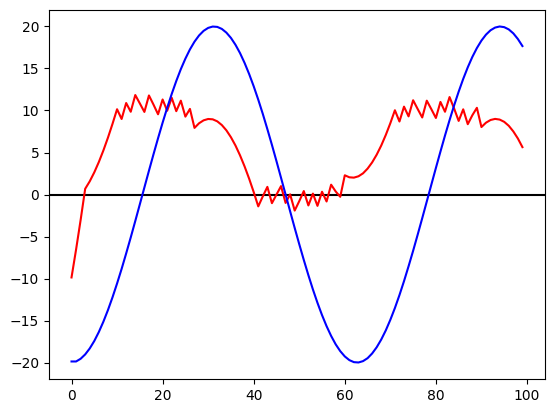

In [62]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), agent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente

## Métrica de Performance
Una posible métrica de performance, podría ser ver la temperatura media del ambiente con la acción del agente.

In [63]:
print("Temperatura media con el agente: ", np.mean(agent_res))
print("Temperatura media sin el agente: ", np.mean(external_res))

Temperatura media con el agente:  5.856500000000003
Temperatura media sin el agente:  0.9514


Otra posible métrica de performance, es evaluar para cada instante de tiempo (step) cuanto difiere la temperatura obtenida de la objetivo=0. Esto se puede hacer con mean_squared_error o mean_absolute_error. 
Comparemos la métrica obtenida por el agente contra la métrica obtenida sin un agente:

In [64]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente: ", mean_absolute_error(goal_temp, agent_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res))

Variación media con el agente:  6.447900000000004
Variación media sin el agente:  13.097800000000001
